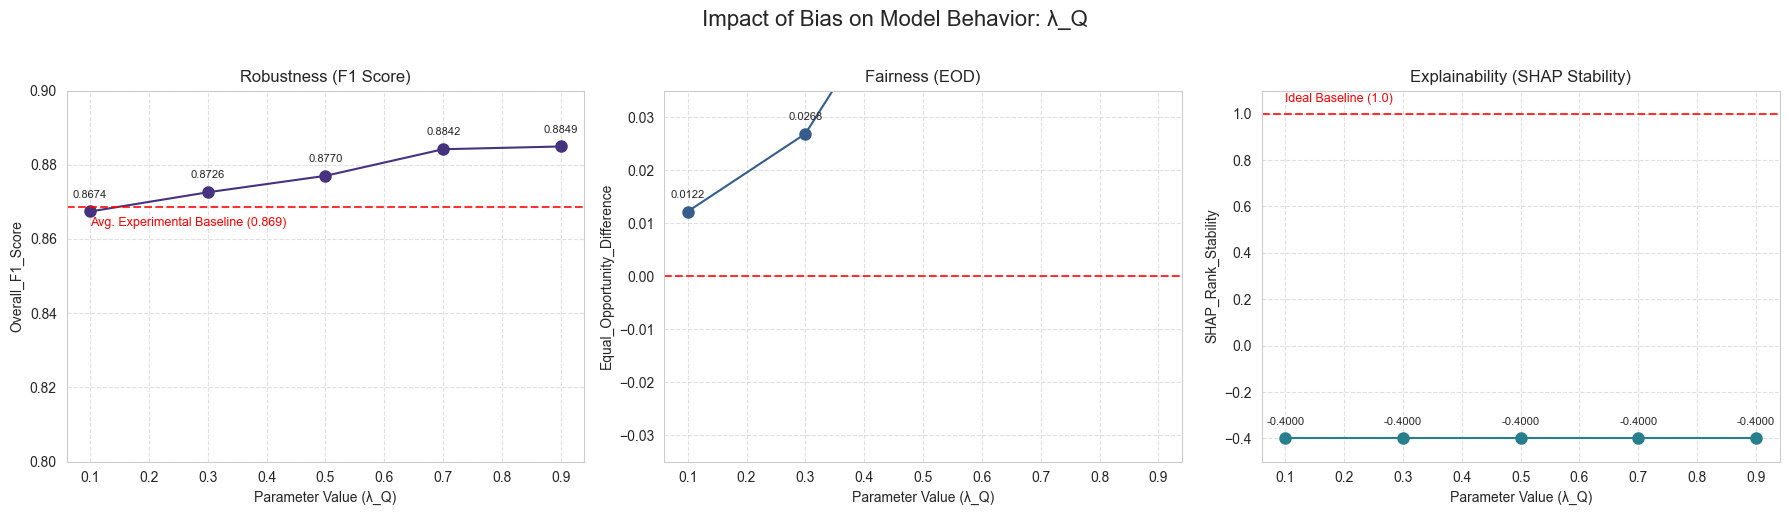

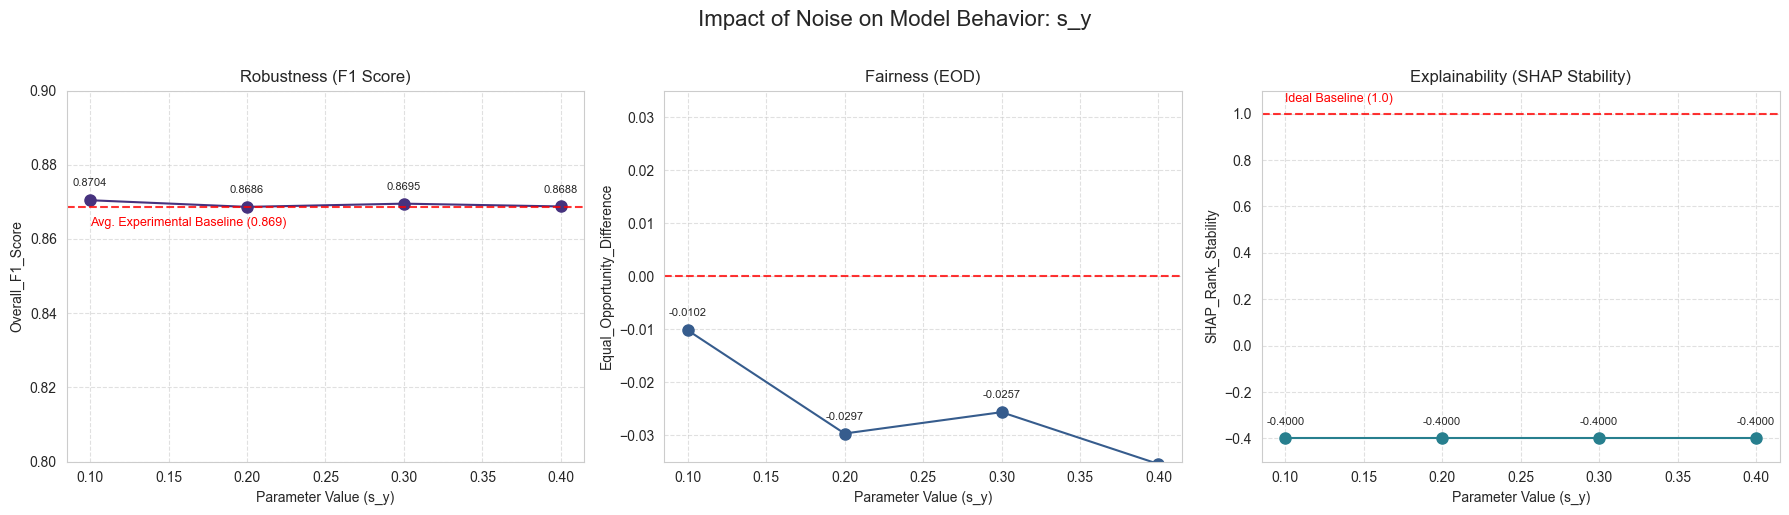

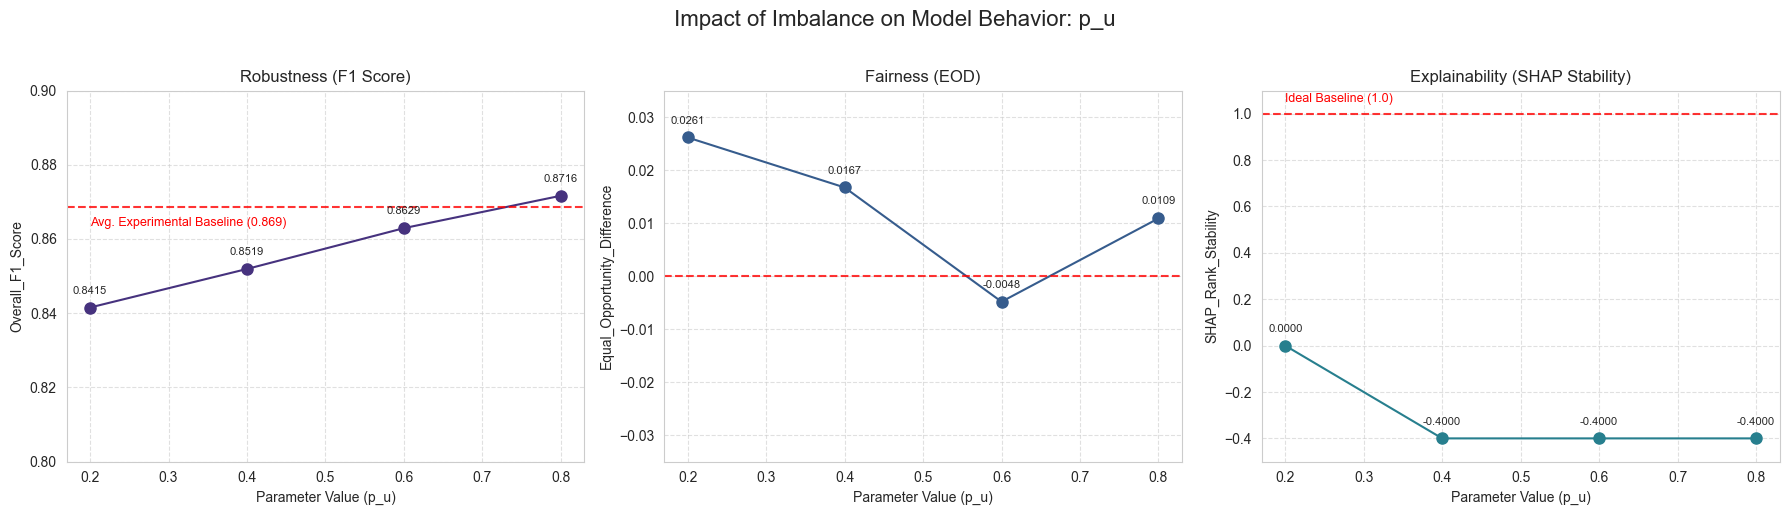

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the visualization style
sns.set_style("whitegrid")

# Name of the results file
MASTER_RESULTS_FILE = 'project_audit_results.csv'

# Load the results
try:
    df = pd.read_csv(MASTER_RESULTS_FILE)
except FileNotFoundError:
    print(f"Error: File '{MASTER_RESULTS_FILE}' not found. Please ensure Phase 3 was executed correctly.")
    exit()

# --- Data Cleaning and Preparation ---

# Separate the flawed baseline row and the experimental data
df_baseline = df[df['Condition'] == 'Baseline'].copy()
df_experiments = df[df['Condition'] != 'Baseline'].copy()
df_experiments['Parameter_Value'] = pd.to_numeric(df_experiments['Parameter_Value'], errors='coerce')
df_experiments['SHAP_Rank_Stability'] = df_experiments['SHAP_Rank_Stability'].round(4)

# Calculate a more stable reference point for Robustness
# Since the baseline F1=0.0 is suspect, we use the mean of the experimental runs as the reference for F1/AUROC.
F1_REF_VALUE = df_experiments['Overall_F1_Score'].mean() 
EOD_REF_VALUE = 0.0 # Ideal fairness
SHAP_REF_VALUE = 1.0 # Ideal SHAP stability

# Separate data into the three experimental series
bias_df = df_experiments[df_experiments['Condition'] == 'bias'].sort_values('Parameter_Value')
noise_df = df_experiments[df_experiments['Condition'] == 'noise'].sort_values('Parameter_Value')
# Lower p_u means higher imbalance (worse condition)
imbalance_df = df_experiments[df_experiments['Condition'] == 'imbalance'].sort_values('Parameter_Value', ascending=False) 

# Map conditions for plotting
condition_map = {
    'bias': 'Bias (λ_Q)',
    'noise': 'Noise (s_y)',
    'imbalance': 'Imbalance (p_u)'
}
df_experiments['Condition_Label'] = df_experiments['Condition'].map(condition_map)

# --- 2. Generation of Structured Plots with Baseline Reference ---

def plot_series(data, condition_name, title_suffix):
    """Generates a combined plot for one experimental series with a baseline reference line."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Impact of {condition_name} on Model Behavior: {title_suffix}', fontsize=16, y=1.02)
    
    # Define metrics, their properties, and reference lines
    metrics = [
        ('Overall_F1_Score', 'Robustness (F1 Score)', (0.8, 0.9), F1_REF_VALUE),
        ('Equal_Opportunity_Difference', 'Fairness (EOD)', (-0.035, 0.035), EOD_REF_VALUE),
        ('SHAP_Rank_Stability', 'Explainability (SHAP Stability)', (-0.5, 1.1), SHAP_REF_VALUE)
    ]
    
    # Plotting loop
    for i, (metric, ylabel, y_limit, ref_value) in enumerate(metrics):
        ax = axes[i]
        color = sns.color_palette("viridis")[i]
        
        # Plot the data points and line
        ax.plot(data['Parameter_Value'], data[metric], marker='o', linestyle='-', color=color, markersize=8)
        
        # Add the Baseline Reference Line
        ax.axhline(ref_value, color='red', linestyle='--', alpha=0.8, label='Reference Baseline')
        
        # Annotation for the reference line
        if metric == 'SHAP_Rank_Stability':
             ax.text(data['Parameter_Value'].min(), ref_value + 0.05, f'Ideal Baseline ({ref_value})', color='red', fontsize=9)
        elif metric == 'Overall_F1_Score':
             ax.text(data['Parameter_Value'].min(), ref_value - 0.005, f'Avg. Experimental Baseline ({ref_value:.3f})', color='red', fontsize=9)
            
        # Set limits and labels
        ax.set_title(ylabel, fontsize=12)
        ax.set_xlabel(f'Parameter Value ({title_suffix})', fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_ylim(y_limit)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add data labels
        for x, y in zip(data['Parameter_Value'], data[metric]):
            ax.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# --- Execute Plotting for Each Series ---

# 1. Bias Series (λ_Q)
plot_series(bias_df, 'Bias', 'λ_Q')

# 2. Noise Series (s_y)
plot_series(noise_df, 'Noise', 's_y')

# 3. Imbalance Series (p_u)
plot_series(imbalance_df, 'Imbalance', 'p_u')